In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##installation of grad-Cam and torchvision    Group-9

In [ ]:
# Install necessary packages
!pip install torch torchvision matplotlib
!pip install grad-cam
!pip install transformers
!pip install transformers torch torchvision shap



##Grad cam

In [ ]:
!pip install torch torchvision matplotlib captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00


##Grad cam:Experiment No 1 Hen

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 47.5MB/s]


5.87558650970459


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


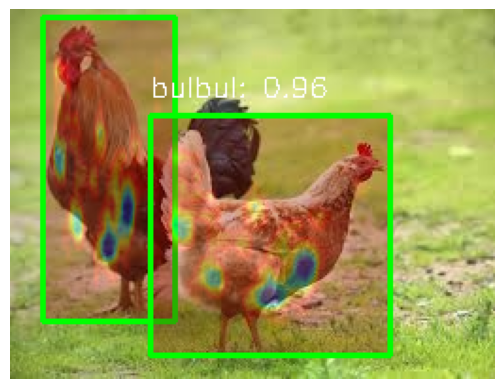

Predictions saved at original_hen_fasterrcnn_gradcam_output.jpg


In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
import torchvision
import os
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
import time
# Load ImageNet class labels (for class names)
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = json.load(urlopen(url))
idx2label = {int(k): v[1] for k, v in class_idx.items()}
start_time=time.time()
# Load pre-trained Faster R-CNN model from torchvision
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to apply Grad-CAM for each detected class
def apply_grad_cam(model, image_path):
    # Load and preprocess the image
    pic = cv2.imread(image_path, 1)
    orig_h, orig_w, _ = pic.shape  # Original dimensions of the image

    # Convert BGR to RGB
    img = pic.copy()
    img = img[:, :, ::-1]
    img = np.ascontiguousarray(img)

    # Convert the image to a tensor
    trans = transforms.Compose([transforms.ToTensor()])
    input_tensor = trans(img).unsqueeze(0)

    # Get predictions using the Faster R-CNN model
    with torch.no_grad():
        prediction = model(input_tensor)

    # Filter the detections
    threshold = 0.5  # Confidence threshold for detecting objects
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # Filter out boxes and labels with scores below the threshold
    keep = scores >= threshold
    boxes = boxes[keep].cpu().numpy()
    labels = labels[keep].cpu().numpy()
    scores = scores[keep].cpu().numpy()

    # Function to generate Grad-CAM heatmap for an image region (bounding box)
    def generate_grad_cam(input_tensor, box):
        activation, grad = [], []

        # Hooks for capturing activations and gradients
        def forward_hook(model, input, output):
            activation.append(output)

        def backward_hook(model, grad_in, grad_out):
            grad.append(grad_out[0])

        # Register hooks on the last convolutional layer
        model.backbone.body.layer4[-1].register_forward_hook(forward_hook)
        model.backbone.body.layer4[-1].register_backward_hook(backward_hook)

        # Forward pass to get activations
        out = model(input_tensor)

        # Get the predicted class
        target_class = out[0]['labels'][0].item()  # Assuming the first detected object

        # Compute loss for backpropagation
        loss = out[0]['scores'][0]

        # Zero gradients and perform backward pass
        model.zero_grad()
        loss.backward()

        # Get the gradients and feature map
        grads = grad[0].cpu().data.numpy().squeeze()
        fmap = activation[0].cpu().data.numpy().squeeze()

        # Calculate the weights for each feature map
        weights = np.mean(grads.reshape(grads.shape[0], -1), axis=1)

        # Generate the CAM
        cam = np.zeros(fmap.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * fmap[i, :]
        cam = np.maximum(cam, 0)
        cam = cam / cam.max() * 255

        # Resize CAM to match the size of the bounding box
        x1, y1, x2, y2 = box.astype(int)
        cam_resized = cv2.resize(cam, (x2 - x1, y2 - y1))
        cam_resized = np.uint8(cam_resized)
        return cam_resized, (x1, y1, x2, y2)

    # Create a copy of the original image for overlay
    cam_img = np.copy(pic)

    # Draw each detected box and class label, and add Grad-CAM heatmap
    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        score = scores[i]
        if score < 0.9:
            continue
        # Get Grad-CAM for the region inside the bounding box
        cam_resized, (x1, y1, x2, y2) = generate_grad_cam(input_tensor, box)

        # Apply the heatmap to the bounding box region
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on the original image within the bounding box area
        cam_img[y1:y2, x1:x2] = np.uint8(0.7 * cam_img[y1:y2, x1:x2] + 0.3 * heatmap)

        # Draw the bounding box
        cv2.rectangle(cam_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Map predicted class index to class label
        predicted_class_name = idx2label.get(label, f'Unknown-{label}')

        # Add predicted class name and score to the image
        label_text = f'{predicted_class_name}: {score:.2f}'
        cv2.putText(cam_img, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Convert image from BGR to RGB for displaying
    cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

    # Save and display the result
    base_name = os.path.basename(image_path).split('.')[0]
    cam_save_path = f'{base_name}_fasterrcnn_gradcam_output.jpg'
    cv2.imwrite(cam_save_path, cv2.cvtColor(cam_img, cv2.COLOR_RGB2BGR))

    # Display the result using matplotlib (which handles RGB format properly)
    plt.imshow(cam_img)
    plt.axis('off')
    plt.show()

    print(f"Predictions saved at {cam_save_path}")
end_time=time.time()
# Calculate the execution time
execution_time = end_time - start_time
print(execution_time)
# Example usage for any image
image_path = '/content/drive/MyDrive/XAI/Images/original_hen.jpg'  # Change this to the path of any image
apply_grad_cam(model, image_path)


##Grad cam Experiment No.2 Tiger And Dog

Mean IoU for predicted boxes: 0.1721
Mean IoU for predicted boxes: 0.1721
IoUs for predicted boxes: [0.49067951093732853, 0.0, 0.10625038783485442, 0.0, 0.43585495406128927, 0.0]


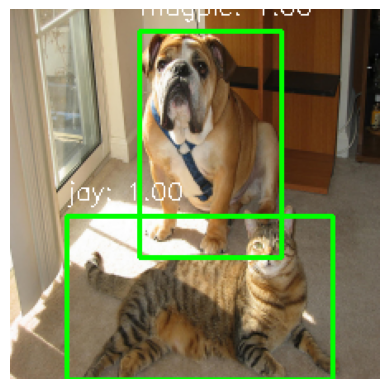

Execution time: 6.92 seconds


In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms, models
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
import os
import time

# Load ImageNet class labels (for class names)
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = json.load(urlopen(url))
idx2label = {int(k): v[1] for k, v in class_idx.items()}

# Load pre-trained Faster R-CNN model from torchvision
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to calculate IoU
def calculate_iou(boxA, boxB):
    x1A, y1A, x2A, y2A = boxA
    x1B, y1B, x2B, y2B = boxB

    x1_inter = max(x1A, x1B)
    y1_inter = max(y1A, y1B)
    x2_inter = min(x2A, x2B)
    y2_inter = min(y2A, y2B)

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    boxA_area = (x2A - x1A) * (y2A - y1A)
    boxB_area = (x2B - x1B) * (y2B - y1B)

    iou = inter_area / float(boxA_area + boxB_area - inter_area) if (boxA_area + boxB_area - inter_area) > 0 else 0
    return iou

# Function to apply Grad-CAM for each detected class
def apply_grad_cam(model, image_path, ground_truth_boxes=None):
    # Load and preprocess the image
    pic = cv2.imread(image_path, 1)
    orig_h, orig_w, _ = pic.shape  # Original dimensions of the image

    # Convert BGR to RGB
    img = pic.copy()
    img = img[:, :, ::-1]
    img = np.ascontiguousarray(img)

    # Convert the image to a tensor
    trans = transforms.Compose([transforms.ToTensor()])
    input_tensor = trans(img).unsqueeze(0)

    # Get predictions using the Faster R-CNN model
    with torch.no_grad():
        prediction = model(input_tensor)

    # Filter the detections
    threshold = 0.5  # Confidence threshold for detecting objects
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # Filter out boxes and labels with scores below the threshold
    keep = scores >= threshold
    boxes = boxes[keep].cpu().numpy()
    labels = labels[keep].cpu().numpy()
    scores = scores[keep].cpu().numpy()

    # Create a copy of the original image for overlay
    cam_img = np.copy(pic)

    # Draw each detected box and class label, and add Grad-CAM heatmap
    ious = []  # List to store IoUs
    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        score = scores[i]
        if score < 0.9:
            continue

        # Draw the bounding box
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(cam_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Map predicted class index to class label
        predicted_class_name = idx2label.get(label, f'Unknown-{label}')

        # Add predicted class name and score to the image
        label_text = f'{predicted_class_name}: {score:.2f}'
        cv2.putText(cam_img, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255 , 255, 255), 1)

        # Calculate IoUs if ground truth boxes are provided
        if ground_truth_boxes is not None:

            ious = []  # List to store IoUs

            for box in boxes:  # boxes are the predicted boxes

                for gt_box in ground_truth_boxes:

                    iou = calculate_iou(box, gt_box)

                    ious.append(iou)


            if ious:  # Check if the list is not empty

                mean_iou = np.mean(ious)  # Calculate mean IoU

                print(f"Mean IoU for predicted boxes: {mean_iou:.4f}")

            else:

                print("No IoUs calculated.")


    # Save and display the result
    base_name = os.path.basename(image_path).split('.')[0]
    cam_save_path = f'{base_name}_fasterrcnn_gradcam_output.jpg'
    cv2.imwrite(cam_save_path, cam_img)

    # Print IoUs if calculated
    if ground_truth_boxes is not None:
        print(f"IoUs for predicted boxes: {ious}")

    # Display the result using matplotlib (which handles RGB format properly)
    plt.imshow(cam_img[:, :, ::-1])  # Convert BGR to RGB for display
    plt.axis('off')
    plt.show()

# Example usage for any image
image_path = '/content/drive/MyDrive/XAI/Images/both.png'  # Change this to the path of any image
# Example ground truth boxes (you should replace this with your actual ground truth)
ground_truth_boxes = [
    np.array([50, 50, 150, 150]),  # Example ground truth box 1
    np.array([200, 200, 300, 300]), # Example ground truth box 2
]

start_time = time.time()
apply_grad_cam(model, image_path, ground_truth_boxes)
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

##Grad cam Experiment No 3 with Tenis Player

tensor([0.9982, 0.9791])


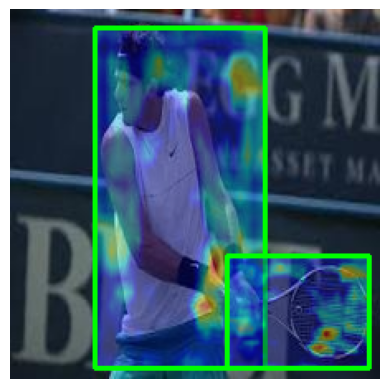

IoU Results: [(1, 0.04), (43, 0.0)]


In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen

# Load ImageNet class labels (for class names)
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = json.load(urlopen(url))
idx2label = {int(k): v[1] for k, v in class_idx.items()}

# Load pre-trained Faster R-CNN model from torchvision
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to calculate IoU
def calculate_iou(gradcam_mask, ground_truth_mask):
    intersection = np.logical_and(gradcam_mask, ground_truth_mask).sum()
    union = np.logical_or(gradcam_mask, ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

# Function to generate binary mask
def generate_binary_mask(cam, threshold=128):
    return (cam > threshold).astype(np.uint8)

# Function to generate Grad-CAM
def generate_grad_cam(model, input_tensor, box):
    activation, grad = [], []

    # Hooks for capturing activations and gradients
    def forward_hook(module, input, output):
        activation.append(output)

    def backward_hook(module, grad_in, grad_out):
        grad.append(grad_out[0])

    # Register hooks on the last convolutional layer
    last_conv_layer = model.backbone.body.layer4[-1]
    forward_hook_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_hook_handle = last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass to get predictions
    out = model(input_tensor)

    # Assuming we focus on the first detection box for simplicity
    loss = out[0]['scores'][0]  # Dummy loss based on the detection score

    # Backpropagate to compute gradients
    model.zero_grad()
    loss.backward()

    # Remove hooks
    forward_hook_handle.remove()
    backward_hook_handle.remove()

    # Compute Grad-CAM
    grads = grad[0].cpu().data.numpy()
    fmap = activation[0].cpu().data.numpy()

    # Compute weights
    weights = np.mean(grads, axis=(2, 3))
    cam = np.zeros(fmap.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * fmap[0, i]

    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / cam.max() * 255.0

    # Resize CAM to match the bounding box dimensions
    x1, y1, x2, y2 = box.cpu().numpy().astype(int)
    cam_resized = cv2.resize(cam, (x2 - x1, y2 - y1))
    cam_resized = np.uint8(cam_resized)

    return cam_resized, (x1, y1, x2, y2)


# Main function to apply Grad-CAM and calculate IoU
def apply_grad_cam_with_iou(model, image_path, ground_truth_path):
    # Load and preprocess the image
    pic = cv2.imread(image_path)  # Load the image
    if pic is None:
        raise ValueError(f"Image not found at {image_path}. Check the file path.")

    orig_h, orig_w, _ = pic.shape
    img = pic[:, :, ::-1]  # Convert BGR to RGB

    # Ensure the array is contiguous
    img = np.ascontiguousarray(img)

    # Convert to tensor
    trans = transforms.Compose([transforms.ToTensor()])
    input_tensor = trans(img).unsqueeze(0)

    # Load the ground truth mask
    ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    if ground_truth_mask is None:
        raise ValueError(f"Ground truth mask not found at {ground_truth_path}. Check the file path.")

    # Resize ground truth mask to match the image dimensions
    ground_truth_mask = cv2.resize(ground_truth_mask, (orig_w, orig_h))

    # Run Faster R-CNN
    with torch.no_grad():
        prediction = model(input_tensor)

    # Filter predictions
    threshold = 0.5
    boxes = prediction[0]['boxes'][prediction[0]['scores'] >= threshold]
    labels = prediction[0]['labels'][prediction[0]['scores'] >= threshold]
    scores = prediction[0]['scores'][prediction[0]['scores'] >= threshold]
    print(scores)
    # if scores>=0.9:

    # Process Grad-CAM
    cam_img = np.copy(pic)
    iou_results = []
    for i, box in enumerate(boxes[:2]):
        cam_resized, (x1, y1, x2, y2) = generate_grad_cam(model, input_tensor, box)
        gradcam_binary_mask = generate_binary_mask(cam_resized)

        # Crop ground truth to match the bounding box
        cropped_gt_mask = ground_truth_mask[y1:y2, x1:x2]

        # Calculate IoU
        # iou = calculate_iou(gradcam_binary_mask, cropped_gt_mask)
        # iou_results.append((labels[i].item(), iou))
        iou = round(calculate_iou(gradcam_binary_mask, cropped_gt_mask), 2)
        iou_results.append((labels[i].item(), iou))
        # Visualize results
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
        cam_img[y1:y2, x1:x2] = np.uint8(0.6 * cam_img[y1:y2, x1:x2] + 0.4 * heatmap)
        cv2.rectangle(cam_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(cam_img, f"IoU: {iou:.2f}", (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Display and save results
    cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cam_img)
    plt.axis('off')
    plt.show()
    print("IoU Results:", iou_results)


# Example usage
image_path = "/content/drive/MyDrive/XAI/Images/tennis_player.jpg"  # Provide your image path
ground_truth_path = "/content/drive/MyDrive/XAI/Images/mask_tennis_person.jpg"  # Provide your ground truth mask path
apply_grad_cam_with_iou(model, image_path, ground_truth_path)


##LIME code

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8baccf273df22a3126a0edb3f42fc0aabbf54bab2b5facb041a30ad9d5938bc0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import time

  0%|          | 0/1000 [00:00<?, ?it/s]

8.157695770263672


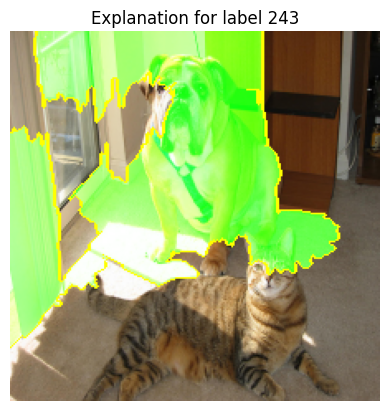

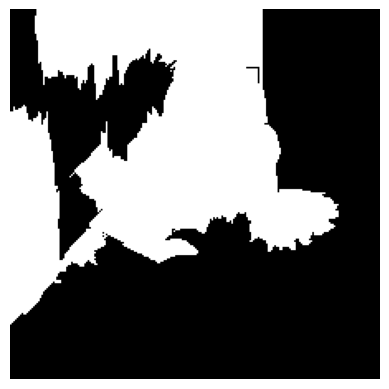

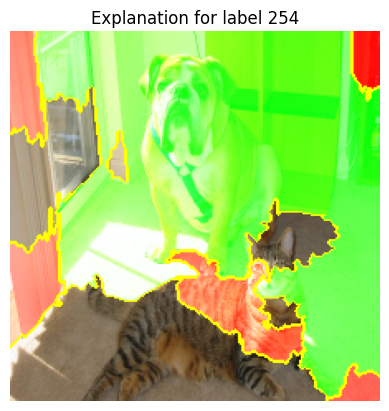

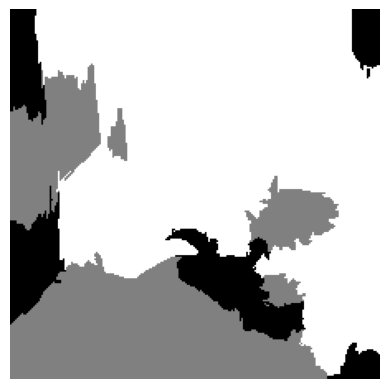

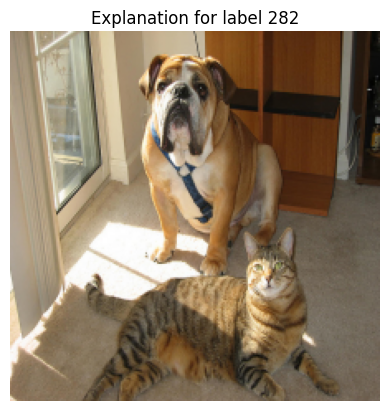

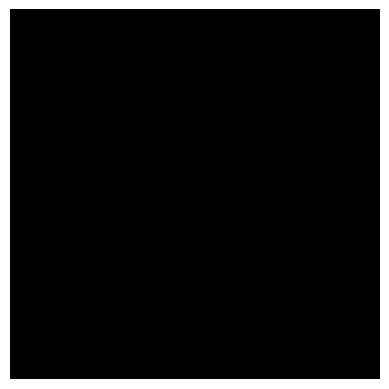

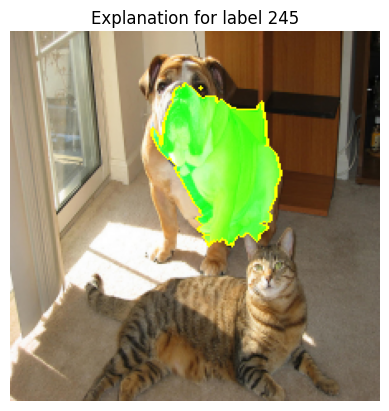

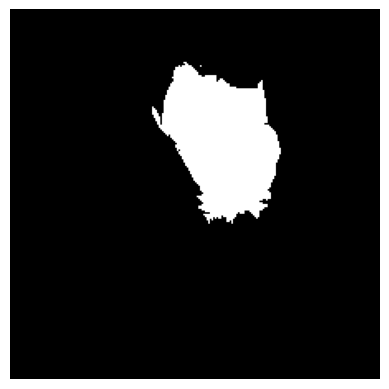

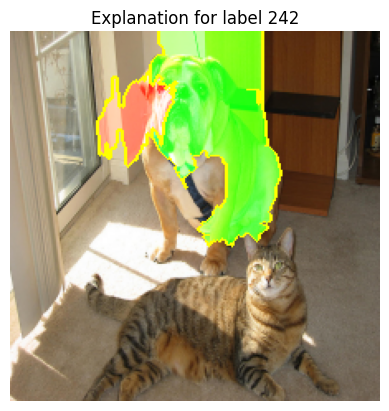

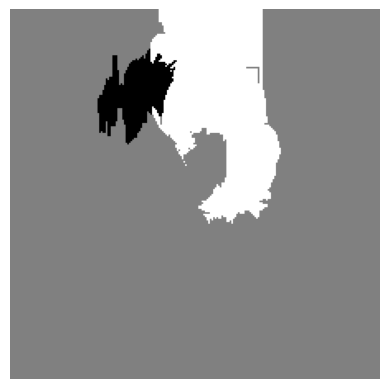

In [ ]:

# Load the original ResNet model (1,000 classes for ImageNet)
model = models.resnet50(pretrained=True)
model.eval()

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

image_tensor = preprocess_image("/content/drive/MyDrive/XAI/Images/both.png")

# Define prediction function for LIME
def predict_function(images):
    images = torch.from_numpy(images).permute(0, 3, 1, 2)
    images = images.float() / 255.0

    if torch.cuda.is_available():
        images = images.cuda()
        model.cuda()

    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()
start_time = time.time()
explanation = explainer.explain_instance(
    image=np.array(Image.open("/content/drive/MyDrive/XAI/Images/both.png").convert('RGB')),
    classifier_fn=predict_function,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)
end_time = time.time()  # End timer

execution_time = end_time - start_time
print(execution_time)
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,
        hide_rest=False,
        num_features=30,
        min_weight=0.01
    )
    plt.figure()
    plt.title(f"Explanation for label {label}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

## GRADE CAM ++ CODE
1.   class detect is :8 Hen
2.   Please Refer all Classes  https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/




##Experiment No.1 Class 8(HEN)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.2MB/s]


Predicted Class: 8
0.921234130859375


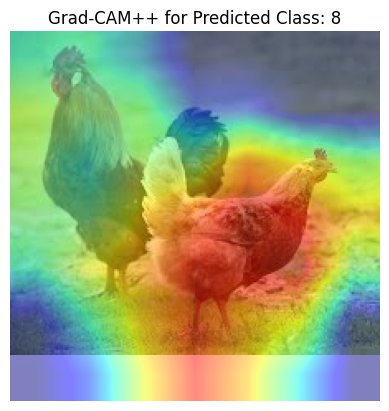

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()
start_time = time.time()
# Define a class for Grad-CAM++ with updated hooks and dimensions handling
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Use `register_full_backward_hook` to avoid FutureWarning
        target_layer.register_full_backward_hook(self.save_gradient)
        target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activation(self, module, input, output):
        self.activations = output

    def generate_heatmap(self, target_class):
        gradients = self.gradients[0]
        activations = self.activations[0]

        # Ensure correct dimensions for activations and gradients
        if gradients.dim() == 3:
            gradients = gradients.unsqueeze(0)
        if activations.dim() == 3:
            activations = activations.unsqueeze(0)

        # Calculate alpha values for Grad-CAM++
        alpha = torch.pow(gradients, 2)
        alpha /= 2 * alpha + torch.pow(activations, 2).sum(dim=(2, 3), keepdim=True)

        # Calculate weights and apply to activations
        weights = torch.sum(alpha * gradients, dim=(2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
        return cam

# Function to predict image class
def predict_image(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

# Define image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image = Image.open('/content/drive/MyDrive/XAI/Images/original_hen.jpg')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the class of the input image
predicted_class = predict_image(model, image_tensor)
print(f"Predicted Class: {predicted_class}")

# Initialize Grad-CAM++ on the chosen layer (e.g., last conv layer in ResNet-50)
target_layer = model.layer4[2].conv3
grad_cam_pp = GradCAMPlusPlus(model, target_layer)

# Perform a backward pass to get gradients for the predicted class
model.zero_grad()
output = model(image_tensor)
class_score = output[0, predicted_class]
class_score.backward()

# Generate the Grad-CAM++ heatmap for the predicted class
heatmap = grad_cam_pp.generate_heatmap(predicted_class)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
# Display the original image and Grad-CAM++ heatmap overlay
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM++ for Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()



##Experiment no 2 Heat Map

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Intersection: 0, Union: 9663, IoU: 0.0
IoU Score: 0.0
Predicted Class: 243 with confidence score: 38.42%

--- GradCAM++ Interpretation ---
The heatmap shows less alignment with the ground truth. The model might be looking at irrelevant areas, indicating low confidence.
Predicted Class: 243 matches the true class! The model is correct.
Percentage of image highlighted by the heatmap as important: 19.26%


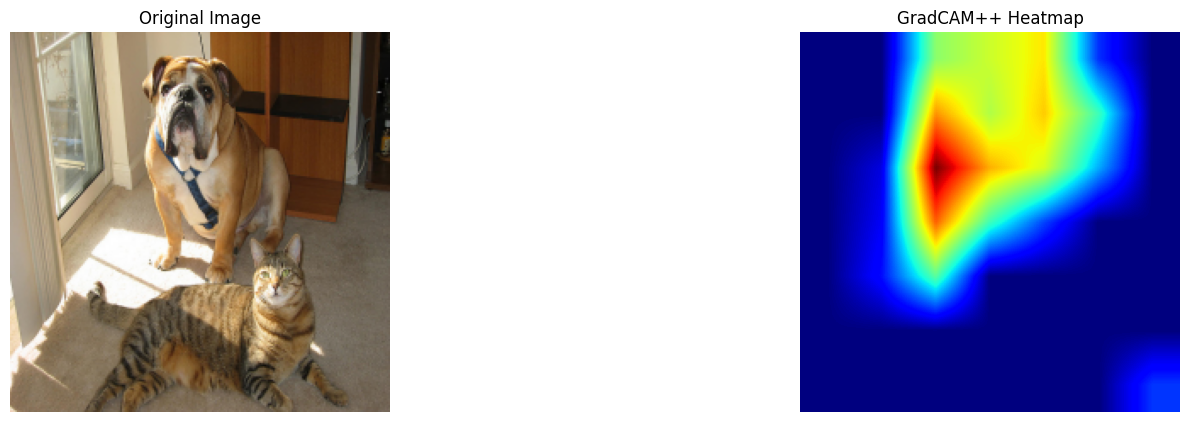

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define the target layer for GradCAM++ (usually the last convolutional layer)
target_layer = model.layer4[2].conv3

# Preprocess the input image
def preprocess_image(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# GradCAM++ calculations
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        # Register hooks to capture gradients and activations
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Attach hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_image, class_idx):
        # Forward pass: pass the image through the model
        output = self.model(input_image)
        self.model.zero_grad()

        # Create a one-hot vector for the class we are interested in
        one_hot = torch.zeros((1, output.size(-1)), dtype=torch.float32)
        one_hot[0][class_idx] = 1

        # Backward pass: backpropagate with respect to the chosen class
        output.backward(gradient=one_hot, retain_graph=True)

        # GradCAM++ calculations
        grads = self.gradients.data.numpy()[0]  # Shape: (2048, 7, 7)
        activations = self.activations.data.numpy()[0]  # Shape: (2048, 7, 7)

        # Calculate alpha and weights for GradCAM++
        alpha = grads**2 / (2 * grads**2 + np.sum(activations * grads**3, axis=(1, 2), keepdims=True) + 1e-7)

        # Print the alpha term calculation for transparency


        weights = np.maximum(grads, 0) * alpha
        weights = np.sum(weights, axis=(1, 2), keepdims=True)

        # Print the weights term for transparency


        # Compute the final Class Activation Map (CAM)
        cam = np.sum(weights * activations, axis=0)

        # Print the computed CAM before ReLU


        # Normalize CAM to range [0, 1]
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cv2.resize(cam, (224, 224))  # Resize to the image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Generate GradCAM++ heatmap and overlay it on the image
def apply_heatmap(heatmap, image):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to a heatmap in 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply a color map
    superimposed_img = heatmap * 0.4 + image  # Overlay heatmap on the original image
    superimposed_img = np.uint8(superimposed_img)  # Convert the superimposed image to uint8
    return superimposed_img

# Calculate Intersection over Union (IoU) between the ground truth mask and the GradCAM++ heatmap
def calculate_iou(ground_truth, heatmap, threshold=0.5):
    binarized_heatmap = (heatmap > threshold).astype(int)  # Binarize the heatmap using threshold
    intersection = np.logical_and(ground_truth, binarized_heatmap).sum()  # Compute intersection
    union = np.logical_or(ground_truth, binarized_heatmap).sum()  # Compute union
    iou = intersection / union if union != 0 else 0  # Calculate IoU
    print(f"Intersection: {intersection}, Union: {union}, IoU: {iou}")
    return iou
def generate_synthetic_mask(image_shape, shape="circle", radius_ratio=0.3):
    """
    Generates a synthetic binary mask with a specific shape (circle or rectangle).
    Parameters:
        image_shape (tuple): Shape of the image as (height, width).
        shape (str): Shape of the mask ('circle' or 'rectangle').
        radius_ratio (float): Radius ratio for circle (relative to image size).
    Returns:
        np.array: Binary mask with the specified shape.
    """
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    if shape == "circle":
        center = (width // 2, height // 2)
        radius = int(min(height, width) * radius_ratio)
        cv2.circle(mask, center, radius, 1, -1)  # Draw filled circle

    elif shape == "rectangle":
        top_left = (int(width * 0.25), int(height * 0.25))
        bottom_right = (int(width * 0.75), int(height * 0.75))
        cv2.rectangle(mask, top_left, bottom_right, 1, -1)  # Draw filled rectangle

    return mask

# Set image dimensions for mask generation
img_shape = (224, 224)  # Same as the resized image dimensions
ground_truth_mask = generate_synthetic_mask(img_shape, shape="circle", radius_ratio=0.3)
# Set paths for the input image and ground truth mask
img_path = '/content/drive/MyDrive/XAI/Images/both.png'  # Path to the image
ground_truth_path = mask  # Path to the ground truth mask

# Preprocess the input image
input_image = preprocess_image(img_path)

# Load ground truth mask (binary mask with 1s for object and 0s for background)
ground_truth_mask = generate_synthetic_mask((224, 224), shape="circle", radius_ratio=0.3)
ground_truth_mask = cv2.resize(ground_truth_mask, (224, 224))
ground_truth_mask = (ground_truth_mask > 128).astype(int)  # Convert to binary mask

# Initialize GradCAM++ with ResNet-50
gradcam_pp = GradCAMPlusPlus(model, target_layer)

# Specify the class index based on your task (example: 243 for "bull mastiff" in ImageNet)
class_idx = 243  # Replace with the relevant class index for your case
heatmap = gradcam_pp(input_image, class_idx)

# Load the original image and apply the GradCAM++ heatmap
original_image = cv2.imread(img_path)
original_image = cv2.resize(original_image, (224, 224))
superimposed_image = apply_heatmap(heatmap, original_image)

# Calculate and print IoU score
iou_score = calculate_iou(ground_truth_mask, heatmap)
print("IoU Score:", iou_score)

# Interpret the results
def interpret_gradcam(heatmap, iou_score, predicted_class, true_class):
    print("\n--- GradCAM++ Interpretation ---")

    # Check if GradCAM++ highlighted regions match the ground truth
    if iou_score > 0.5:
        print("The heatmap is highly aligned with the ground truth. The model is confident and focused on relevant areas of the image.")
    else:
        print("The heatmap shows less alignment with the ground truth. The model might be looking at irrelevant areas, indicating low confidence.")

    # Show predicted class and accuracy
    if predicted_class == true_class:
        print(f"Predicted Class: {predicted_class} matches the true class! The model is correct.")
    else:
        print(f"Predicted Class: {predicted_class} does not match the true class ({true_class}). The model is incorrect.")

    # Highlighting most important regions
    important_area_percentage = np.sum(heatmap > 0.5) / heatmap.size * 100
    print(f"Percentage of image highlighted by the heatmap as important: {important_area_percentage:.2f}%")

# Get the predicted class and compare with the true label
model_output = model(input_image)
predicted_class = torch.argmax(model_output, 1).item()
true_class = class_idx  # Set the true class index as the class we're using for GradCAM++
class_prob = torch.nn.functional.softmax(model_output, dim=1)[0][predicted_class].item()

# Print the predicted class and confidence
print(f"Predicted Class: {predicted_class} with confidence score: {class_prob * 100:.2f}%")

# Interpret the GradCAM++ result
interpret_gradcam(heatmap, iou_score, predicted_class, true_class)

# Displaying the images using matplotlib for visualization
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# # Superimposed Image (GradCAM++ Heatmap Overlay)
# plt.subplot(1, 3, 2)
# plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
# plt.title('GradCAM++ Overlay')
# plt.axis('off')

# Heatmap itself
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap='jet')
plt.title('GradCAM++ Heatmap')
plt.axis('off')

plt.tight_layout()  # Corrected line to arrange the layout
plt.show()


##Grade CAM++ for New which will show Highlighted portion which which was learned by Model  Group :9

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


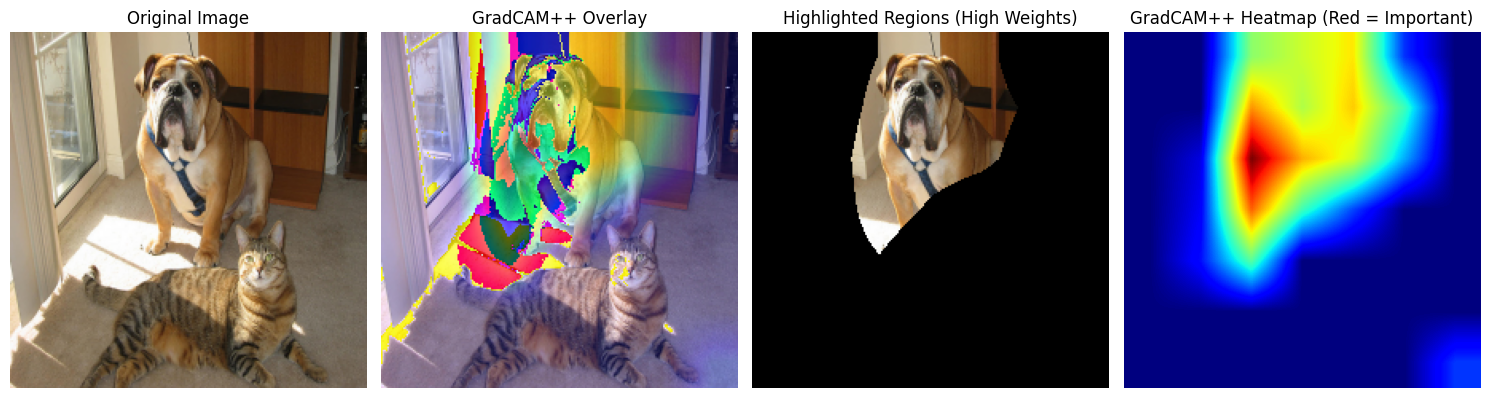

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define the target layer for GradCAM++ (usually the last convolutional layer)
target_layer = model.layer4[2].conv3

# Preprocess the input image
def preprocess_image(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# GradCAM++ calculations
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        # Register hooks to capture gradients and activations
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Attach hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_image, class_idx):
        # Forward pass: pass the image through the model
        output = self.model(input_image)
        self.model.zero_grad()

        # Create a one-hot vector for the class we are interested in
        one_hot = torch.zeros((1, output.size(-1)), dtype=torch.float32)
        one_hot[0][class_idx] = 1

        # Backward pass: backpropagate with respect to the chosen class
        output.backward(gradient=one_hot, retain_graph=True)

        # GradCAM++ calculations
        grads = self.gradients.data.numpy()[0]  # Shape: (2048, 7, 7)
        activations = self.activations.data.numpy()[0]  # Shape: (2048, 7, 7)

        # Calculate alpha and weights for GradCAM++
        alpha = grads**2 / (2 * grads**2 + np.sum(activations * grads**3, axis=(1, 2), keepdims=True) + 1e-7)
        weights = np.maximum(grads, 0) * alpha
        weights = np.sum(weights, axis=(1, 2), keepdims=True)

        # Compute the final Class Activation Map (CAM)
        cam = np.sum(weights * activations, axis=0)

        # Normalize CAM to range [0, 1]
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cv2.resize(cam, (224, 224))  # Resize to the image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Generate GradCAM++ heatmap and overlay it on the image
def apply_heatmap(heatmap, image):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to a heatmap in 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply a color map
    superimposed_img = heatmap * 0.4 + image  # Overlay heatmap on the original image
    superimposed_img = np.uint8(superimposed_img)  # Convert the superimposed image to uint8
    return superimposed_img

# Set paths for the input image and ground truth mask
img_path = '/content/drive/MyDrive/XAI/Images/both.png'  # Path to the image

# Preprocess the input image
input_image = preprocess_image(img_path)

# Initialize GradCAM++ with ResNet-50
gradcam_pp = GradCAMPlusPlus(model, target_layer)

# Specify the class index based on your task (example: 243 for "bull mastiff" in ImageNet)
class_idx = 243  # Replace with the relevant class index for your case
heatmap = gradcam_pp(input_image, class_idx)

# Load the original image and apply the GradCAM++ heatmap
original_image = cv2.imread(img_path)
original_image = cv2.resize(original_image, (224, 224))
superimposed_image = apply_heatmap(heatmap, original_image)

# Extract high-weight regions (intense regions in the heatmap)
high_weight_mask = heatmap > 0.5  # You can adjust the threshold to focus on stronger regions
highlighted_regions = original_image.copy()
highlighted_regions[~high_weight_mask] = 0  # Masking out non-high-weight areas

# Displaying the images using matplotlib for visualization
plt.figure(figsize=(15, 6))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Superimposed Image (GradCAM++ Heatmap Overlay)
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('GradCAM++ Overlay')
plt.axis('off')

# Highlighted Regions
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(highlighted_regions, cv2.COLOR_BGR2RGB))
plt.title('Highlighted Regions (High Weights)')
plt.axis('off')

# Heatmap itself
plt.subplot(1, 4, 4)
plt.imshow(heatmap, cmap='jet')
plt.title('GradCAM++ Heatmap (Red = Important)')
plt.axis('off')

plt.tight_layout()  # Corrected line to arrange the layout with proper space
plt.show()

## Grad CAM++ for different Layer Detection  done by Group-9
1.   Predicted Class 1:243 bull mastiff dog
2.   Predicted Class 2:282 tiger cat
3.   Predicted Class 3:242 boxer
4.   Predicted Class 4:281 tabby, tabby cat
5.   Predicted Class 5:539 doormat, welcome mat

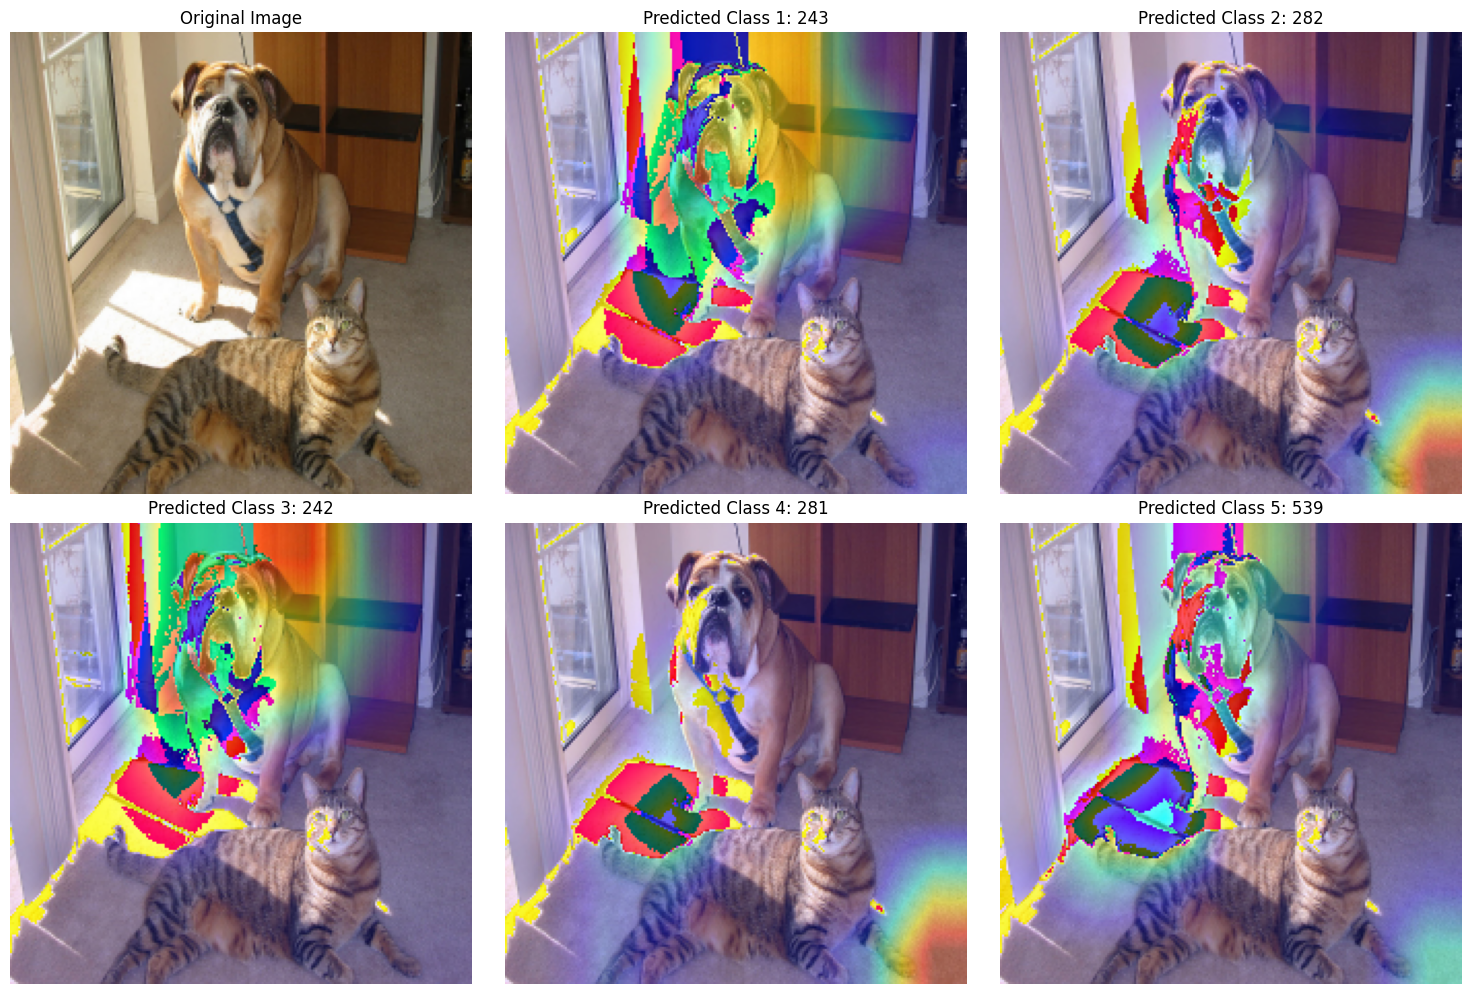


Highlighted Region for Predicted Class 1 (Class Index 243):
Important features: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17954846 0.17954846 0.17954846]
 [0.         0.         0.         ... 0.17954846 0.17954846 0.17954846]
 [0.         0.         0.         ... 0.17954846 0.17954846 0.17954846]]

Highlighted Region for Predicted Class 2 (Class Index 282):
Important features: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]

Highlighted Region for Predicted Class 3 (Class Index 242):
Important features: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.       

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define the target layer for GradCAM++ (usually the last convolutional layer)
target_layer = model.layer4[2].conv3

# Preprocess the input image
def preprocess_image(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# GradCAM++ calculations
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        # Register hooks to capture gradients and activations
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Attach hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_image, class_idx):
        # Forward pass: pass the image through the model
        output = self.model(input_image)
        self.model.zero_grad()

        # Create a one-hot vector for the class we are interested in
        one_hot = torch.zeros((1, output.size(-1)), dtype=torch.float32)
        one_hot[0][class_idx] = 1

        # Backward pass: backpropagate with respect to the chosen class
        output.backward(gradient=one_hot, retain_graph=True)

        # GradCAM++ calculations
        grads = self.gradients.data.numpy()[0]  # Shape: (2048, 7, 7)
        activations = self.activations.data.numpy()[0]  # Shape: (2048, 7, 7)

        # Calculate alpha and weights for GradCAM++
        alpha = grads**2 / (2 * grads**2 + np.sum(activations * grads**3, axis=(1, 2), keepdims=True) + 1e-7)
        weights = np.maximum(grads, 0) * alpha
        weights = np.sum(weights, axis=(1, 2), keepdims=True)

        # Compute the final Class Activation Map (CAM)
        cam = np.sum(weights * activations, axis=0)

        # Normalize CAM to range [0, 1]
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cv2.resize(cam, (224, 224))  # Resize to the image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Generate GradCAM++ heatmap and overlay it on the image
def apply_heatmap(heatmap, image):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to a heatmap in 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply a color map
    superimposed_img = heatmap * 0.4 + image  # Overlay heatmap on the original image
    superimposed_img = np.uint8(superimposed_img)  # Convert the superimposed image to uint8
    return superimposed_img

# Set paths for the input image and ground truth mask
img_path = '/content/drive/MyDrive/XAI/Images/both.png'  # Path to the image

# Preprocess the input image
input_image = preprocess_image(img_path)

# Initialize GradCAM++ with ResNet-50
gradcam_pp = GradCAMPlusPlus(model, target_layer)

# Run inference for multiple classes in the image (e.g., top-5 predicted classes)
output = model(input_image)
_, predicted_classes = torch.topk(output, k=5)

# Generate heatmaps for top-5 predicted classes
heatmaps = []
superimposed_images = []

# Process each predicted class
for i in range(5):
    class_idx = predicted_classes[0][i].item()
    heatmap = gradcam_pp(input_image, class_idx)
    heatmaps.append(heatmap)

    # Load original image and apply heatmap for visualization
    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (224, 224))
    superimposed_image = apply_heatmap(heatmap, original_image)
    superimposed_images.append(superimposed_image)

# Displaying images with proper spacing
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display Heatmaps and Superimposed Images
for i in range(5):
    plt.subplot(2, 3, i+2)
    plt.imshow(cv2.cvtColor(superimposed_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted Class {i+1}: {predicted_classes[0][i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Printing highlighted regions for each class
for i in range(5):
    print(f"\nHighlighted Region for Predicted Class {i+1} (Class Index {predicted_classes[0][i].item()}):")
    print(f"Important features: {heatmaps[i]}")

##practice

In [ ]:
# from captum.attr import LayerGradCam

# # Specify the layer within ResNet-50 for Grad-CAM
# target_layer = model.layer4[2]  # Last layer in ResNet's layer4

# # Initialize LayerGradCam with the specified layer
# layer_gc = LayerGradCam(model, target_layer)

# # Assuming `img_tensor` is your preprocessed image tensor and `target_class` is the class index for Grad-CAM
# grad_cam_attr = layer_gc.attribute(img_tensor, target=target_class)


In [ ]:
# import torch
# from torchvision.models import resnet50

# model = resnet50(pretrained=True)
# model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 31.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# from torchvision import transforms
# from PIL import Image

# # Load the image
# image_path = '/content/download (2).jpeg'
# input_image = Image.open(image_path)

# # Define the transformations
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Preprocess the image
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

In [ ]:
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

# # Initialize GradCAM
# target_layers = [model.layer4[-1]]  # Specify the target layer
# cam = GradCAM(model=model, target_layers=target_layers)

# # Generate the CAM
# grayscale_cam = cam(input_tensor=input_batch, targets=None)  # You can specify targets if needed
# grayscale_cam = grayscale_cam[0, :]  # Get the first image's CAM

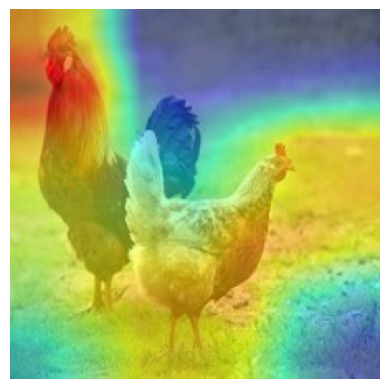

In [ ]:
# import numpy as np
# # Convert the original image to a format suitable for visualization
# rgb_img = input_image.resize((224, 224))  # Resize to match the model input size
# rgb_img = np.array(rgb_img) / 255.0  # Normalize to [0, 1]

# # Show the CAM on the image
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# # Display the result
# import matplotlib.pyplot as plt

# plt.imshow(visualization)
# plt.axis('off')
# plt.show()

In [ ]:
pip install torch torchvision matplotlib


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Alpha Calculation:
[[[ 0.49749804  0.49749804  0.49749804 ...  0.          0.
    0.        ]
  [ 0.          0.49749804  0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.49749804  0.49749804  0.49749804 ...  0.49749804  0.49749804
    0.49749804]
  [ 0.          0.49749804  0.49749804 ...  0.49749804  0.49749804
    0.49749804]
  [ 0.          0.49749804  0.49749804 ...  0.49749804  0.49749804
    0.49749804]]

 [[ 0.50055844  0.50055844  0.50055844 ...  0.50055844 -0.
   -0.        ]
  [ 0.50055844  0.50055844  0.50055844 ...  0.50055844  0.50055844
   -0.        ]
  [-0.         -0.          0.50055844 ...  0.50055844  0.50055844
   -0.        ]
  ...
  [-0.         -0.          0.50055844 ... -0.         -0.
   -0.        ]
  [ 0.50055844  0.50055844  0.50055844 ... -0.         -0.
   -0.        ]
  [ 0.50055844  0.50055844  0.50055844 ... -0.         -0.
   -0.        ]]

 [[ 0.49969798  0.4996979

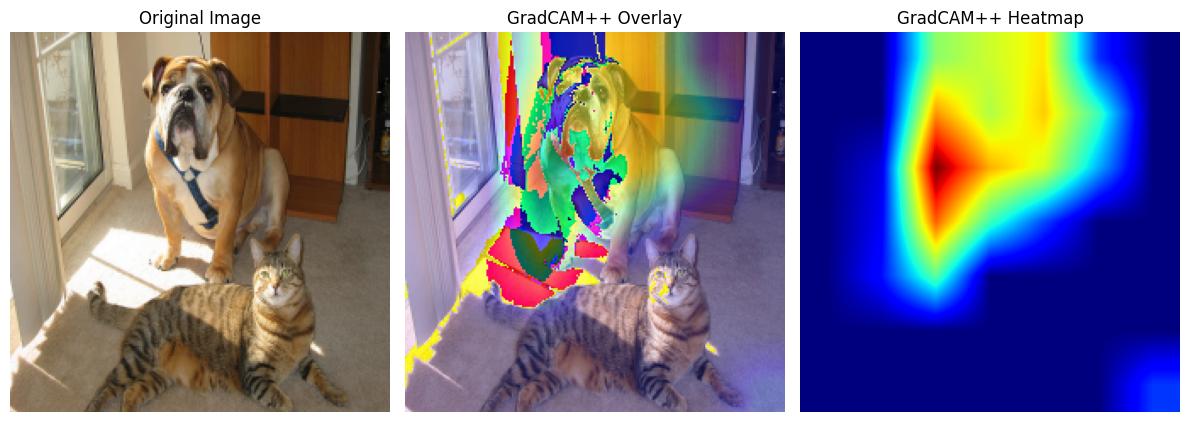

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define the target layer for GradCAM++ (usually the last convolutional layer)
target_layer = model.layer4[2].conv3

# Preprocess the input image
def preprocess_image(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# GradCAM++ calculations
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        # Register hooks to capture gradients and activations
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Attach hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_image, class_idx):
        # Forward pass: pass the image through the model
        output = self.model(input_image)
        self.model.zero_grad()

        # Create a one-hot vector for the class we are interested in
        one_hot = torch.zeros((1, output.size(-1)), dtype=torch.float32)
        one_hot[0][class_idx] = 1

        # Backward pass: backpropagate with respect to the chosen class
        output.backward(gradient=one_hot, retain_graph=True)

        # GradCAM++ calculations
        grads = self.gradients.data.numpy()[0]  # Shape: (2048, 7, 7)
        activations = self.activations.data.numpy()[0]  # Shape: (2048, 7, 7)

        # Calculate alpha and weights for GradCAM++
        alpha = grads**2 / (2 * grads**2 + np.sum(activations * grads**3, axis=(1, 2), keepdims=True) + 1e-7)

        # Print the alpha term calculation for transparency
        print("Alpha Calculation:")
        print(alpha)

        weights = np.maximum(grads, 0) * alpha
        weights = np.sum(weights, axis=(1, 2), keepdims=True)

        # Print the weights term for transparency
        print("Weights Calculation (before summing over spatial dimensions):")
        print(weights)

        # Compute the final Class Activation Map (CAM)
        cam = np.sum(weights * activations, axis=0)

        # Print the computed CAM before ReLU
        print("Class Activation Map (before ReLU):")
        print(cam)

        # Normalize CAM to range [0, 1]
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cv2.resize(cam, (224, 224))  # Resize to the image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Generate GradCAM++ heatmap and overlay it on the image
def apply_heatmap(heatmap, image):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to a heatmap in 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply a color map
    superimposed_img = heatmap * 0.4 + image  # Overlay heatmap on the original image
    superimposed_img = np.uint8(superimposed_img)  # Convert the superimposed image to uint8
    return superimposed_img

# Calculate Intersection over Union (IoU) between the ground truth mask and the GradCAM++ heatmap
def calculate_iou(ground_truth, heatmap, threshold=0.5):
    binarized_heatmap = (heatmap > threshold).astype(int)  # Binarize the heatmap using threshold
    intersection = np.logical_and(ground_truth, binarized_heatmap).sum()  # Compute intersection
    union = np.logical_or(ground_truth, binarized_heatmap).sum()  # Compute union
    iou = intersection / union if union != 0 else 0  # Calculate IoU
    print(f"Intersection: {intersection}, Union: {union}, IoU: {iou}")
    return iou

# Set paths for the input image and ground truth mask
img_path = '/content/both.png'  # Path to the image
ground_truth_path = '/content/segmentation_cat.png'  # Path to the ground truth mask

# Preprocess the input image
input_image = preprocess_image(img_path)

# Load ground truth mask (binary mask with 1s for object and 0s for background)
ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
ground_truth_mask = cv2.resize(ground_truth_mask, (224, 224))
ground_truth_mask = (ground_truth_mask > 128).astype(int)  # Convert to binary mask

# Initialize GradCAM++ with ResNet-50
gradcam_pp = GradCAMPlusPlus(model, target_layer)

# Specify the class index based on your task (example: 243 for "bull mastiff" in ImageNet)
class_idx = 243  # Replace with the relevant class index for your case
heatmap = gradcam_pp(input_image, class_idx)

# Load the original image and apply the GradCAM++ heatmap
original_image = cv2.imread(img_path)
original_image = cv2.resize(original_image, (224, 224))
superimposed_image = apply_heatmap(heatmap, original_image)

# Calculate and print IoU score
iou_score = calculate_iou(ground_truth_mask, heatmap)
print("IoU Score:", iou_score)

# Interpret the results
def interpret_gradcam(heatmap, iou_score, predicted_class, true_class):
    print("\n--- GradCAM++ Interpretation ---")

    # Check if GradCAM++ highlighted regions match the ground truth
    if iou_score > 0.5:
        print("The heatmap is highly aligned with the ground truth. The model is confident and focused on relevant areas of the image.")
    else:
        print("The heatmap shows less alignment with the ground truth. The model might be looking at irrelevant areas, indicating low confidence.")

    # Show predicted class and accuracy
    if predicted_class == true_class:
        print(f"Predicted Class: {predicted_class} matches the true class! The model is correct.")
    else:
        print(f"Predicted Class: {predicted_class} does not match the true class ({true_class}). The model is incorrect.")

    # Highlighting most important regions
    important_area_percentage = np.sum(heatmap > 0.5) / heatmap.size * 100
    print(f"Percentage of image highlighted by the heatmap as important: {important_area_percentage:.2f}%")

# Get the predicted class and compare with the true label
model_output = model(input_image)
predicted_class = torch.argmax(model_output, 1).item()
true_class = class_idx  # Set the true class index as the class we're using for GradCAM++
class_prob = torch.nn.functional.softmax(model_output, dim=1)[0][predicted_class].item()

# Print the predicted class and confidence
print(f"Predicted Class: {predicted_class} with confidence score: {class_prob * 100:.2f}%")

# Interpret the GradCAM++ result
interpret_gradcam(heatmap, iou_score, predicted_class, true_class)

# Displaying the images using matplotlib for visualization
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Superimposed Image (GradCAM++ Heatmap Overlay)
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('GradCAM++ Overlay')
plt.axis('off')

# Heatmap itself
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap='jet')
plt.title('GradCAM++ Heatmap')
plt.axis('off')

plt.tight_layout()  # Corrected line to arrange the layout
plt.show()


##mask_generator

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


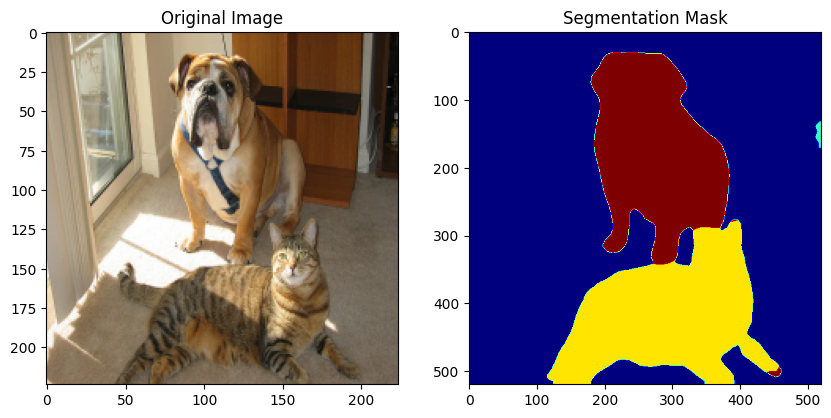

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load pre-trained DeepLabv3 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

# Function to preprocess image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0), image

# Generate mask
def get_segmentation_mask(image_tensor):
    with torch.no_grad():
        output = model(image_tensor)['out'][0]
    return output.argmax(0).byte().cpu().numpy()

# Input image
image_path = "/content/both.png"  # Replace with your image path
image_tensor, original_image = preprocess_image(image_path)

# Get mask
mask = get_segmentation_mask(image_tensor)

# Visualize result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask")
plt.imshow(mask, cmap="jet")
plt.show()


In [ ]:
def save_mask(mask, output_path):
    # Normalize the mask to 0-255 for saving as an image
    mask_image = Image.fromarray((mask * 255 / mask.max()).astype(np.uint8))
    mask_image.save(output_path)
    print(f"Mask saved at: {output_path}")

# Specify output path for the mask image
output_mask_path = "segmentation_mask.png"  # Replace with your desired file path

# Save the mask
save_mask(mask, output_mask_path)

Mask saved at: segmentation_mask.png


## Important step ,please mount the drive first :Group -9

##LIME ,GradCAD and GRAD CAM++ computational time

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b0419024d731d4680122f9e230681c238529a261c18a9027e1eedec793923582
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

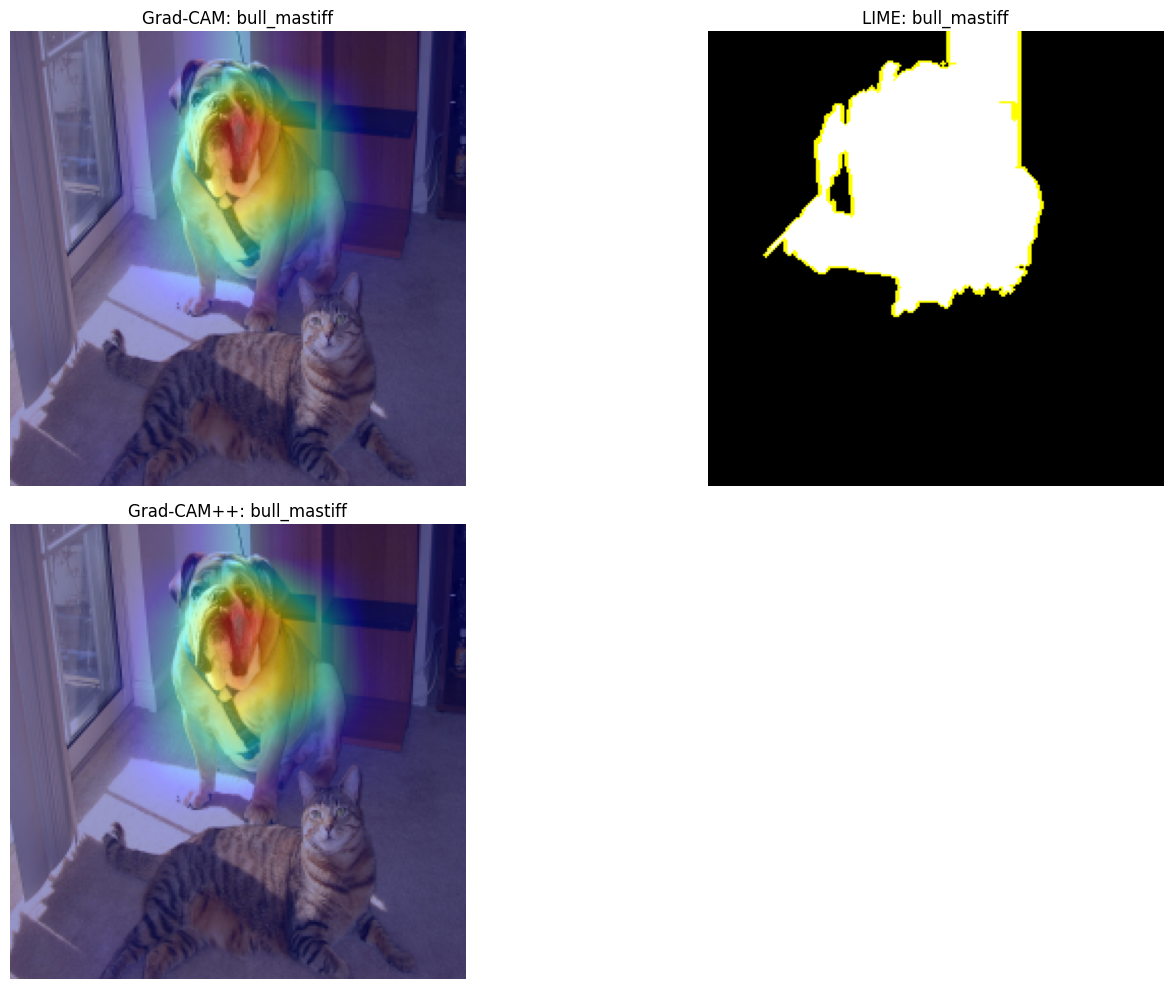

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from lime import lime_image
import cv2
from skimage.segmentation import mark_boundaries
import time

# ---------------------- 0. Load Model and Image ----------------------
# Load a pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Load and preprocess the image
img_path = '/content/drive/MyDrive/XAI/Images/both.png'  # Update with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# Predict the class of the image
predictions = model.predict(img_array)
class_idx = np.argmax(predictions)
class_label = tf.keras.applications.resnet50.decode_predictions(predictions, top=1)[0][0][1]

# ---------------------- 1. Grad-CAM ----------------------
def grad_cam(model, img_array, class_idx):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer('conv5_block3_out').output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()

    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    return heatmap

# Generate Grad-CAM heatmap
grad_cam_heatmap = grad_cam(model, img_array, class_idx)
grad_cam_img = cv2.applyColorMap(np.uint8(255 * grad_cam_heatmap), cv2.COLORMAP_JET)
grad_cam_superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, grad_cam_img, 0.4, 0)

# ---------------------- 2. Grad-CAM++ ----------------------
def grad_cam_plus_plus(model, img_array, class_idx):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer('conv5_block3_out').output, model.output]
    )

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(img_tensor)
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]

    # Compute first-order gradients
    grads = tape.gradient(loss, conv_output)
    if grads is None:
        raise ValueError("First-order gradients could not be computed.")

    # Compute second-order gradients
    second_grads = tape.gradient(grads, conv_output)
    if second_grads is None:
        print("Warning: Second-order gradients could not be computed. Defaulting to Grad-CAM.")
        return grad_cam(model, img_array, class_idx)

    # Compute pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_second_grads = tf.reduce_mean(second_grads, axis=(0, 1, 2))

    # Apply Grad-CAM++ weight calculation
    conv_output = conv_output[0].numpy()
    heatmap = np.zeros_like(conv_output[:, :, 0])

    for i in range(conv_output.shape[-1]):
        weight = pooled_grads[i] + 2 * pooled_second_grads[i]
        heatmap += weight * conv_output[:, :, i]

    # Normalize and resize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

# Generate Grad-CAM++ heatmap
grad_cam_plus_plus_heatmap = grad_cam_plus_plus(model, img_array, class_idx)
grad_cam_plus_plus_img = cv2.applyColorMap(np.uint8(255 * grad_cam_plus_plus_heatmap), cv2.COLORMAP_JET)
grad_cam_plus_plus_superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, grad_cam_plus_plus_img, 0.4, 0)

# ---------------------- 3. LIME ----------------------
def lime_explanation(model, img_path):
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = tf.keras.applications.resnet50.preprocess_input(images)
        return model.predict(images)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(class_idx, positive_only=True, hide_rest=True)
    return mark_boundaries(temp, mask)

# Generate LIME explanation
lime_img = lime_explanation(model, img_path)

# ---------------------- 4. Plot Results ----------------------
plt.figure(figsize=(15, 10))

# Plot Grad-CAM
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(grad_cam_superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM: {class_label}")
plt.axis('off')

# Plot LIME
plt.subplot(2, 2, 2)
plt.imshow(lime_img)
plt.title(f"LIME: {class_label}")
plt.axis('off')

# Plot Grad-CAM++
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(grad_cam_plus_plus_superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM++: {class_label}")
plt.axis('off')

plt.tight_layout()
plt.show()

# ---------------------- 5. Computational Cost ----------------------
start_time = time.time()
grad_cam(model, img_array, class_idx)
grad_cam_time = time.time() - start_time

start_time = time.time()
lime_explanation(model, img_path)
lime_time = time.time() - start_time

start_time = time.time()
grad_cam_plus_plus(model, img_array, class_idx)
grad_cam_plus_plus_time = time.time() - start_time

print(f"Computational cost (time) for Grad-CAM: {grad_cam_time:.4f} seconds")
print(f"Computational cost (time) for LIME: {lime_time:.4f} seconds")
print(f"Computational cost (time) for Grad-CAM++: {grad_cam_plus_plus_time:.4f} seconds")


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0b55c7d732eb6b985409ed12afc232f387e9a259e89f47d718ae5b7b8aec0691
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

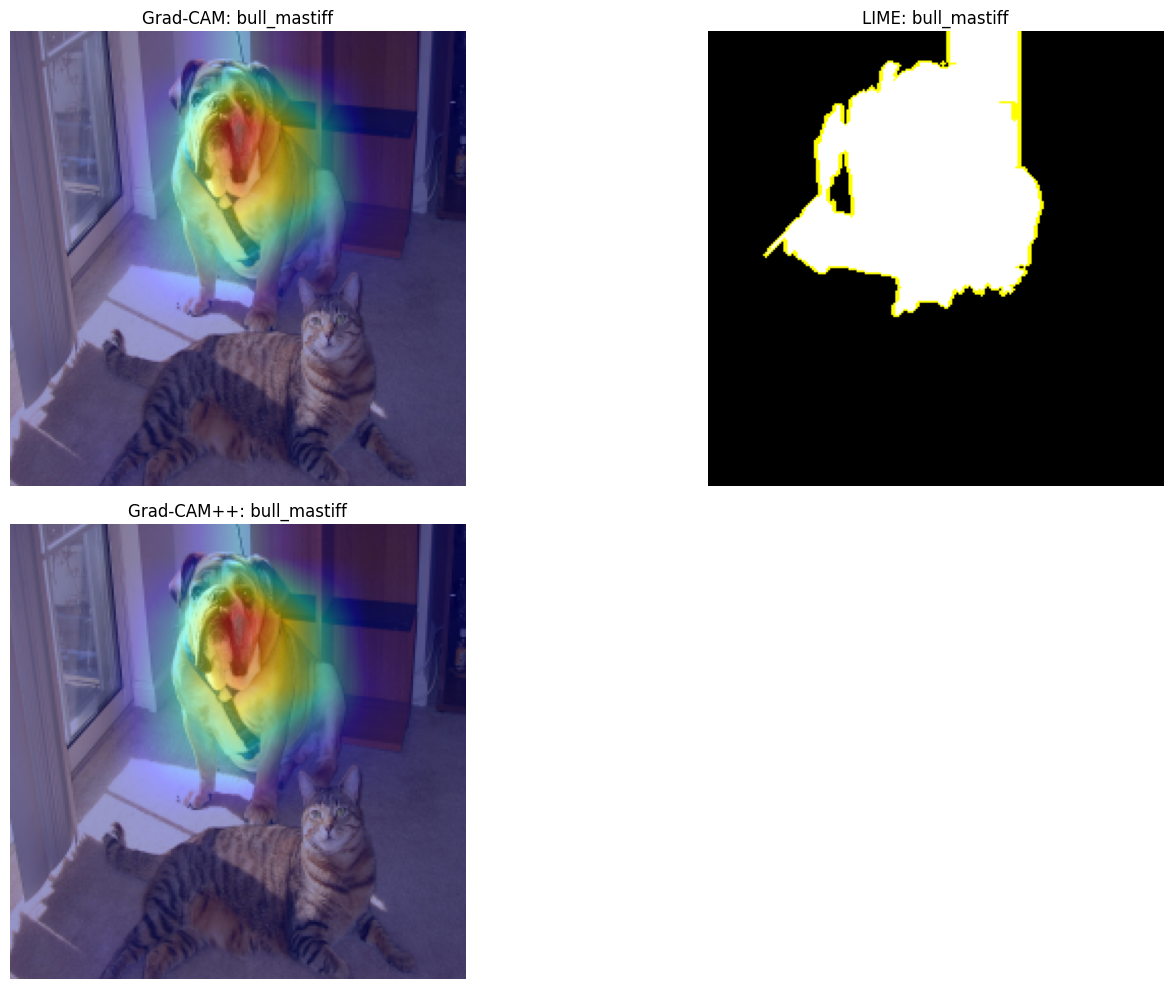

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from lime import lime_image
import cv2
from skimage.segmentation import mark_boundaries
import time

# ---------------------- 0. Load Model and Image ----------------------
# Load a pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Load and preprocess the image
img_path = '/content/drive/MyDrive/XAI/Images/both.png'  # Update with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# Predict the class of the image
predictions = model.predict(img_array)
class_idx = np.argmax(predictions)
class_label = tf.keras.applications.resnet50.decode_predictions(predictions, top=1)[0][0][1]

# ---------------------- 1. Grad-CAM ----------------------
def grad_cam(model, img_array, class_idx):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer('conv5_block3_out').output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()

    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

# ---------------------- 2. Grad-CAM++ ----------------------
def grad_cam_plus_plus(model, img_array, class_idx):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer('conv5_block3_out').output, model.output]
    )

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(img_tensor)
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]

    # Compute first-order gradients
    grads = tape.gradient(loss, conv_output)
    if grads is None:
        raise ValueError("First-order gradients could not be computed.")

    # Compute second-order gradients
    second_grads = tape.gradient(grads, conv_output)
    if second_grads is None:
        print("Warning: Second-order gradients could not be computed. Defaulting to Grad-CAM.")
        return grad_cam(model, img_array, class_idx)

    # Compute pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_second_grads = tf.reduce_mean(second_grads, axis=(0, 1, 2))

    # Apply Grad-CAM++ weight calculation
    conv_output = conv_output[0].numpy()
    heatmap = np.zeros_like(conv_output[:, :, 0])

    for i in range(conv_output.shape[-1]):
        weight = pooled_grads[i] + 2 * pooled_second_grads[i]
        heatmap += weight * conv_output[:, :, i]

    # Normalize and resize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

# ---------------------- 3. LIME ----------------------
def lime_explanation(model, img_path):
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = tf.keras.applications.resnet50.preprocess_input(images)
        return model.predict(images)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(class_idx, positive_only=True, hide_rest=True)
    return mark_boundaries(temp, mask)

# ---------------------- 4. Plot Results ----------------------
plt.figure(figsize=(15, 10))

# Plot Grad-CAM
plt.subplot(2, 2, 1)
grad_cam_heatmap = grad_cam(model, img_array, class_idx)
grad_cam_img = cv2.applyColorMap(np.uint8(255 * grad_cam_heatmap), cv2.COLORMAP_JET)
grad_cam_superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, grad_cam_img, 0.4, 0)
plt.imshow(cv2.cvtColor(grad_cam_superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM: {class_label}")
plt.axis('off')

# Plot LIME
plt.subplot(2, 2, 2)
lime_img = lime_explanation(model, img_path)
plt.imshow(lime_img)
plt.title(f"LIME: {class_label}")
plt.axis('off')

# Plot Grad-CAM++
plt.subplot(2, 2, 3)
grad_cam_plus_plus_heatmap = grad_cam_plus_plus(model, img_array, class_idx)
grad_cam_plus_plus_img = cv2.applyColorMap(np.uint8(255 * grad_cam_plus_plus_heatmap), cv2.COLORMAP_JET)
grad_cam_plus_plus_superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, grad_cam_plus_plus_img, 0.4, 0)
plt.imshow(cv2.cvtColor(grad_cam_plus_plus_superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM++: {class_label}")
plt.axis('off')

plt.tight_layout()
plt.show()

# ---------------------- 5. Computational Cost ----------------------
start_time = time.time()
grad_cam(model, img_array, class_idx)
grad_cam_time = time.time() - start_time

start_time = time.time()
lime_explanation(model, img_path)
lime_time = time.time() - start_time

start_time = time.time()
grad_cam_plus_plus(model, img_array, class_idx)
grad_cam_plus_plus_time = time.time() - start_time

print(f"Computational cost (time) for Grad-CAM: {grad_cam_time:.4f} seconds")
print(f"Computational cost (time) for LIME: {lime_time:.4f} seconds")
print(f"Computational cost (time) for Grad-CAM++: {grad_cam_plus_plus_time:.4f} seconds")


##resize

In [ ]:
from PIL import Image

def resize_and_save_image(image_path, output_path, size=(224, 224)):
    # Open the image
    image = Image.open(image_path)

    # Resize the image to 224x224
    resized_image = image.resize(size)

    # Save the resized image
    resized_image.save(output_path)

# Example usage
resize_and_save_image("/content/segmentation_person.png", "/content/segmentation_person.png")

##LIME with IOU

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6f9988a2a860b4aaf2c6831501cb2244ef240e854dcb04f1100c1c6ee9b714ba
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import time

In [ ]:

# Load the original ResNet model (1,000 classes for ImageNet)
model = models.resnet50(pretrained=True)
model.eval()

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

image_tensor = preprocess_image("/content/drive/MyDrive/XAI/Images/both.png")

# Define prediction function for LIME
def predict_function(images):
    images = torch.from_numpy(images).permute(0, 3, 1, 2)
    images = images.float() / 255.0

    if torch.cuda.is_available():
        images = images.cuda()
        model.cuda()

    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()
start_time = time.time()
explanation = explainer.explain_instance(
    image=np.array(Image.open("/content/drive/MyDrive/XAI/Images/both.png").convert('RGB')),
    classifier_fn=predict_function,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)
end_time = time.time()  # End timer

execution_time = end_time - start_time
print(execution_time)
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,
        hide_rest=False,
        num_features=30,
        min_weight=0.01
    )
    plt.figure()
    plt.title(f"Explanation for label {label}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
!pip install torch torchvision lime matplotlib scikit-image


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.5MB/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

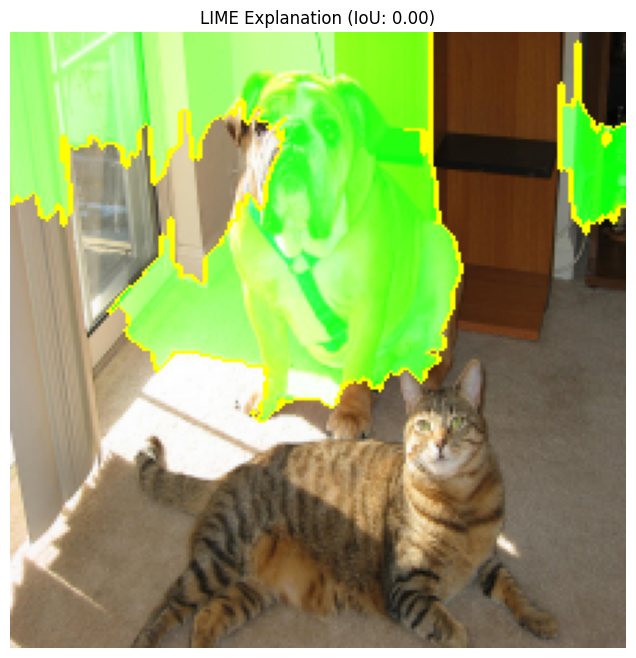

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
import time

# Function to calculate IoU
def calculate_iou(lime_mask, ground_truth_mask):
    intersection = np.logical_and(lime_mask, ground_truth_mask).sum()
    union = np.logical_or(lime_mask, ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

# Prediction function for LIME
def predict_function(images):
    images = torch.from_numpy(images).permute(0, 3, 1, 2)
    images = images.float() / 255.0

    if torch.cuda.is_available():
        images = images.cuda()
        model.cuda()

    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

# Apply LIME and display results with IoU
def apply_lime_with_iou(image_path, ground_truth_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    if ground_truth_mask is None:
        raise ValueError(f"Ground truth mask not found at {ground_truth_path}. Check the file path.")

    # Resize ground truth to match the input image
    ground_truth_mask = cv2.resize(ground_truth_mask, (224, 224))
    ground_truth_binary = (ground_truth_mask > 128).astype(np.uint8)  # Convert to binary mask

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=np.array(image),
        classifier_fn=predict_function,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Generate and display explanation for the top label
    top_label = explanation.top_labels[0]
    temp, lime_mask = explanation.get_image_and_mask(
        label=top_label,
        positive_only=False,
        hide_rest=False,
        num_features=30,
        min_weight=0.01
    )

    # Convert LIME mask to binary
    lime_binary_mask = (lime_mask > 0).astype(np.uint8)

    # Calculate IoU
    iou = calculate_iou(lime_binary_mask, ground_truth_binary)

    # Plot the image with IoU displayed
    plt.figure(figsize=(8, 8))
    plt.title(f"LIME Explanation (IoU: {iou:.2f})")
    plt.imshow(mark_boundaries(temp / 255.0, lime_mask))
    plt.axis('off')
    plt.show()

# Load the ResNet model
model = models.resnet50(pretrained=True)
model.eval()

# Example usage
image_path = "/content/cat_and_dog.png"  # Provide your image path
ground_truth_path = "/content/segmentation_cat.png"  # Provide your ground truth mask path
apply_lime_with_iou(image_path, ground_truth_path)


##Grad cam ++ with IOU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Class: 243
Execution Time: 1.16s
IoU: 0.00


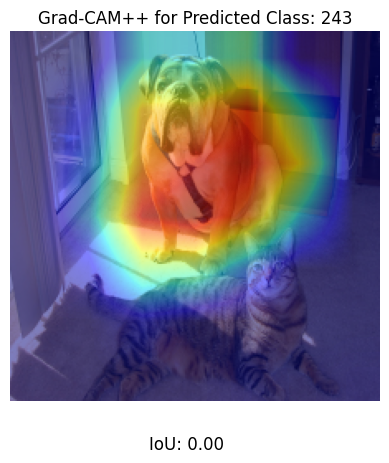

In [7]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()
start_time = time.time()

# Define Grad-CAM++ class
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_full_backward_hook(self.save_gradient)
        target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activation(self, module, input, output):
        self.activations = output

    def generate_heatmap(self, target_class):
        gradients = self.gradients[0]
        activations = self.activations[0]

        # Ensure correct dimensions
        if gradients.dim() == 3:
            gradients = gradients.unsqueeze(0)
        if activations.dim() == 3:
            activations = activations.unsqueeze(0)

        # Calculate alpha values
        alpha = torch.pow(gradients, 2)
        alpha /= 2 * alpha + torch.pow(activations, 2).sum(dim=(2, 3), keepdim=True)

        # Calculate weights and apply to activations
        weights = torch.sum(alpha * gradients, dim=(2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
        return cam

# Function to calculate IoU
def calculate_iou(gradcam_mask, ground_truth_mask):
    intersection = np.logical_and(gradcam_mask, ground_truth_mask).sum()
    union = np.logical_or(gradcam_mask, ground_truth_mask).sum()
    return intersection / union if union > 0 else 0

# Function to predict image class
def predict_image(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

# Preprocessing transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image_path = '/content/cat_and_dog.png'
ground_truth_path = '/content/segmentation_cat.png'  # Provide the ground truth mask path
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the class of the input image
predicted_class = predict_image(model, image_tensor)
print(f"Predicted Class: {predicted_class}")

# Initialize Grad-CAM++ on the chosen layer
target_layer = model.layer4[2].conv3
grad_cam_pp = GradCAMPlusPlus(model, target_layer)

# Perform a backward pass to get gradients for the predicted class
model.zero_grad()
output = model(image_tensor)
class_score = output[0, predicted_class]
class_score.backward()

# Generate the Grad-CAM++ heatmap
heatmap = grad_cam_pp.generate_heatmap(predicted_class)

# Load and preprocess the ground truth mask
ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
if ground_truth_mask is None:
    raise ValueError(f"Ground truth mask not found at {ground_truth_path}.")
ground_truth_mask = cv2.resize(ground_truth_mask, (224, 224))
ground_truth_binary = (ground_truth_mask > 128).astype(np.uint8)  # Convert to binary

# Convert Grad-CAM++ heatmap to binary mask
gradcam_binary_mask = (heatmap > 0.5).astype(np.uint8)

# Calculate IoU
iou = calculate_iou(gradcam_binary_mask, ground_truth_binary)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f}s")
print(f"IoU: {iou:.2f}")

# Display the image with Grad-CAM++ heatmap overlay and IoU
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM++ for Predicted Class: {predicted_class}")
plt.axis('off')
plt.figtext(0.5, 0.01, f"IoU: {iou:.2f}", ha="center", fontsize=12, color="black")
plt.show()


## grad cam with IUO

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 124MB/s]


tensor([0.9996, 0.9965, 0.8132])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


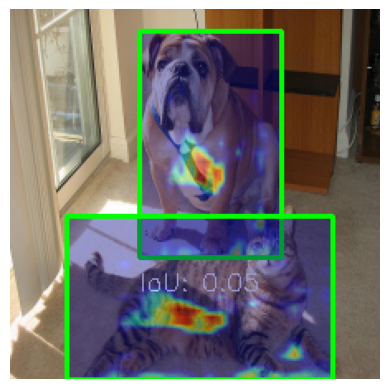

IoU Results: [(18, 0.05), (17, 0.06)]


In [8]:
import cv2
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen

# Load ImageNet class labels (for class names)
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = json.load(urlopen(url))
idx2label = {int(k): v[1] for k, v in class_idx.items()}

# Load pre-trained Faster R-CNN model from torchvision
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to calculate IoU
def calculate_iou(gradcam_mask, ground_truth_mask):
    intersection = np.logical_and(gradcam_mask, ground_truth_mask).sum()
    union = np.logical_or(gradcam_mask, ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

# Function to generate binary mask
def generate_binary_mask(cam, threshold=128):
    return (cam > threshold).astype(np.uint8)

# Function to generate Grad-CAM
def generate_grad_cam(model, input_tensor, box):
    activation, grad = [], []

    # Hooks for capturing activations and gradients
    def forward_hook(module, input, output):
        activation.append(output)

    def backward_hook(module, grad_in, grad_out):
        grad.append(grad_out[0])

    # Register hooks on the last convolutional layer
    last_conv_layer = model.backbone.body.layer4[-1]
    forward_hook_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_hook_handle = last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass to get predictions
    out = model(input_tensor)

    # Assuming we focus on the first detection box for simplicity
    loss = out[0]['scores'][0]  # Dummy loss based on the detection score

    # Backpropagate to compute gradients
    model.zero_grad()
    loss.backward()

    # Remove hooks
    forward_hook_handle.remove()
    backward_hook_handle.remove()

    # Compute Grad-CAM
    grads = grad[0].cpu().data.numpy()
    fmap = activation[0].cpu().data.numpy()

    # Compute weights
    weights = np.mean(grads, axis=(2, 3))
    cam = np.zeros(fmap.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * fmap[0, i]

    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / cam.max() * 255.0

    # Resize CAM to match the bounding box dimensions
    x1, y1, x2, y2 = box.cpu().numpy().astype(int)
    cam_resized = cv2.resize(cam, (x2 - x1, y2 - y1))
    cam_resized = np.uint8(cam_resized)

    return cam_resized, (x1, y1, x2, y2)


# Main function to apply Grad-CAM and calculate IoU
def apply_grad_cam_with_iou(model, image_path, ground_truth_path):
    # Load and preprocess the image
    pic = cv2.imread(image_path)  # Load the image
    if pic is None:
        raise ValueError(f"Image not found at {image_path}. Check the file path.")

    orig_h, orig_w, _ = pic.shape
    img = pic[:, :, ::-1]  # Convert BGR to RGB

    # Ensure the array is contiguous
    img = np.ascontiguousarray(img)

    # Convert to tensor
    trans = transforms.Compose([transforms.ToTensor()])
    input_tensor = trans(img).unsqueeze(0)

    # Load the ground truth mask
    ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    if ground_truth_mask is None:
        raise ValueError(f"Ground truth mask not found at {ground_truth_path}. Check the file path.")

    # Resize ground truth mask to match the image dimensions
    ground_truth_mask = cv2.resize(ground_truth_mask, (orig_w, orig_h))

    # Run Faster R-CNN
    with torch.no_grad():
        prediction = model(input_tensor)

    # Filter predictions
    threshold = 0.5
    boxes = prediction[0]['boxes'][prediction[0]['scores'] >= threshold]
    labels = prediction[0]['labels'][prediction[0]['scores'] >= threshold]
    scores = prediction[0]['scores'][prediction[0]['scores'] >= threshold]
    print(scores)
    # if scores>=0.9:

    # Process Grad-CAM
    cam_img = np.copy(pic)
    iou_results = []
    for i, box in enumerate(boxes[:2]):
        cam_resized, (x1, y1, x2, y2) = generate_grad_cam(model, input_tensor, box)
        gradcam_binary_mask = generate_binary_mask(cam_resized)

        # Crop ground truth to match the bounding box
        cropped_gt_mask = ground_truth_mask[y1:y2, x1:x2]

        # Calculate IoU
        # iou = calculate_iou(gradcam_binary_mask, cropped_gt_mask)
        # iou_results.append((labels[i].item(), iou))
        iou = round(calculate_iou(gradcam_binary_mask, cropped_gt_mask), 2)
        iou_results.append((labels[i].item(), iou))
        # Visualize results
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
        cam_img[y1:y2, x1:x2] = np.uint8(0.6 * cam_img[y1:y2, x1:x2] + 0.4 * heatmap)
        cv2.rectangle(cam_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(cam_img, f"IoU: {iou:.2f}", (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Display and save results
    cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cam_img)
    plt.axis('off')
    plt.show()
    print("IoU Results:", iou_results)


# Example usage
image_path = "/content/cat_and_dog.png"  # Provide your image path
ground_truth_path = "/content/segmentation_cat.png"  # Provide your ground truth mask path
apply_grad_cam_with_iou(model, image_path, ground_truth_path)
